# Shor's Algorithm to Factor Numbers up to 247

### Ben Sachs, Ishaan Kavoori, Kirtan Shah, Thomas Sievert

In this project we:
- Implement the Shor's Algorithm
- Find the factorization of a number that is the product of two primes.
- Find factors of numbers up to 247


Qiskit provides code to calculate the factors of 15 (3 and 5) and we
extended this algorithm to work with numbers up to 247.

## Run our code to see it in action

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
from math import gcd, ceil
from numpy.random import randint
import pandas as pd
from fractions import Fraction
from math import gcd # greatest common divisor
import random

### Helper function to convert a value to binary represented in qubits

In [ ]:
def convertToCircuit(val):
    # does some garbage
    U = QuantumCircuit(4)
    
    if val >= 8:
        U.x(0)
    if val % 8 >= 4:
        U.x(1)
    if val % 4 >= 2:
        U.x(2)
    if val % 2 == 0:
        U.x(3)
        
    return U

### Returns a circuit (gate) that calculates a<sup>power</sup> mod n.

In [ ]:
def amodn(a, n, power):
    U = convertToCircuit(pow(a, power, n))
    U = U.to_gate()
    U.name = "%i^%i mod %i" % (a, power, n)
    c_U = U.control()
    return c_U

### N = number to factor, feel free to change value below (max value 247).

In [4]:
N = 247 # 19*13

### Initialize qubit registers and randomly select initial guess.

In [5]:
# Specify variables
n_count = 8  # number of counting qubits
w_count = 4

a = -1
while a == -1 or gcd(a, N) != 1:
    a = random.randint(2, int(ceil(N**0.5)))
print("Initial Guess: " + str(a))

Initial Guess: 14


### Apply QFT<sup>†</sup> matrix to extract period of f(x) = a<sup>x</sup> mod *N*

In [6]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

### Construct the quantum circuit and draw diagram

In [7]:
# Create QuantumCircuit with n_count counting qubits
# plus 4 qubits for U to act on
qc = QuantumCircuit(n_count + w_count, n_count)

# Initialise counting qubits
# in state |+>
for q in range(n_count):
    qc.h(q)
    
# And auxiliary register in state |1>
qc.x(3+n_count)

# Do controlled-U operations
for q in range(n_count):
    qc.append(amodn(a, N, 2**q), 
             [q] + [i+n_count for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(n_count), range(n_count))

# Measure circuit
qc.measure(range(n_count), range(n_count))
qc.draw(fold=-1)  # -1 means 'do not fold'

┌───┐                                                                                                                                             ┌───────┐┌─┐                     
 q_0: ┤ H ├────────■────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0      ├┤M├─────────────────────
      ├───┤        │                                                                                                                                    │       │└╥┘┌─┐                  
 q_1: ┤ H ├────────┼────────────────■───────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤1      ├─╫─┤M├──────────────────
      ├───┤        │                │                                                                                                                   │       │ ║ └╥┘┌─┐               
 q_2: ┤ H ├────────┼────────────────┼────────────────■──────────────────────────────────────────────────────────────────────────────────────────────────┤2      ├─╫──╫─┤M├───────────────
      ├───┤        │                │                │                                                                                                  │       │ ║  ║ └╥┘┌─┐            
 q_3: ┤ H ├────────┼────────────────┼────────────────┼────────────────■─────────────────────────────────────────────────────────────────────────────────┤3      ├─╫──╫──╫─┤M├────────────
      ├───┤        │                │                │                │                                                                                 │  QFT† │ ║  ║  ║ └╥┘┌─┐         
 q_4: ┤ H ├────────┼────────────────┼────────────────┼────────────────┼────────────────■────────────────────────────────────────────────────────────────┤4      ├─╫──╫──╫──╫─┤M├─────────
      ├───┤        │                │                │                │                │                                                                │       │ ║  ║  ║  ║ └╥┘┌─┐      
 q_5: ┤ H ├────────┼────────────────┼────────────────┼────────────────┼────────────────┼─────────────────■──────────────────────────────────────────────┤5      ├─╫──╫──╫──╫──╫─┤M├──────
      ├───┤        │                │                │                │                │                 │                                              │       │ ║  ║  ║  ║  ║ └╥┘┌─┐   
 q_6: ┤ H ├────────┼────────────────┼────────────────┼────────────────┼────────────────┼─────────────────┼─────────────────■────────────────────────────┤6      ├─╫──╫──╫──╫──╫──╫─┤M├───
      ├───┤        │                │                │                │                │                 │                 │                            │       │ ║  ║  ║  ║  ║  ║ └╥┘┌─┐
 q_7: ┤ H ├────────┼────────────────┼────────────────┼────────────────┼────────────────┼─────────────────┼─────────────────┼──────────────────■─────────┤7      ├─╫──╫──╫──╫──╫──╫──╫─┤M├
      └───┘┌───────┴───────┐┌───────┴───────┐┌───────┴───────┐┌───────┴───────┐┌───────┴────────┐┌───────┴────────┐┌───────┴────────┐┌────────┴────────┐└───────┘ ║  ║  ║  ║  ║  ║  ║ └╥┘
 q_8: ─────┤0              ├┤0              ├┤0              ├┤0              ├┤0               ├┤0               ├┤0               ├┤0                ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
           │               ││               ││               ││               ││                ││                ││                ││                 │          ║  ║  ║  ║  ║  ║  ║  ║ 
 q_9: ─────┤1              ├┤1              ├┤1              ├┤1              ├┤1               ├┤1               ├┤1               ├┤1                ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
           │  14^1 mod 247 ││  14^2 mod 247 ││  14^4 mod 247 ││  14^8 mod 247 ││  14^16 mod 247 ││  14^32 mod 247 ││  14^64 mod 247 ││  14^128 mod 247 │          ║  ║  ║  ║  ║  ║  ║  ║ 
q_10: ─────┤2              ├┤2              ├┤2              ├┤2              ├┤2               ├┤2 

### Execute simulation and plot measurements of quantum circuit

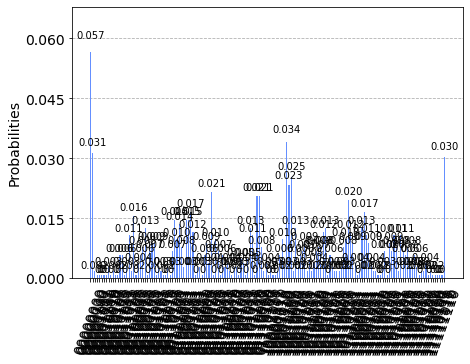

In [8]:
qasm_sim = Aer.get_backend('qasm_simulator')
t_qc = transpile(qc, qasm_sim)
qobj = assemble(t_qc)
results = qasm_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

### Print register output with computed phase

In [9]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n_count)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                 f"{decimal}/{2**n_count} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

              Register Output           Phase
0    00000000(bin) =   0(dec)    0/256 = 0.00
1    00010010(bin) =  18(dec)   18/256 = 0.07
2    00010011(bin) =  19(dec)   19/256 = 0.07
3    00010100(bin) =  20(dec)   20/256 = 0.08
4    00010101(bin) =  21(dec)   21/256 = 0.08
..                        ...             ...
151  11110101(bin) = 245(dec)  245/256 = 0.96
152  11110110(bin) = 246(dec)  246/256 = 0.96
153  11110111(bin) = 247(dec)  247/256 = 0.96
154  11111010(bin) = 250(dec)  250/256 = 0.98
155  11111110(bin) = 254(dec)  254/256 = 0.99

[156 rows x 2 columns]


### Print guesses for "r" in Shor's Algorithm

In [10]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(N)
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

        Phase Fraction  Guess for r
0    0.000000      0/1            1
1    0.070312    9/128          128
2    0.074219   17/229          229
3    0.078125     5/64           64
4    0.082031   16/195          195
..        ...      ...          ...
151  0.957031  156/163          163
152  0.960938  123/128          128
153  0.964844  192/199          199
154  0.976562  125/128          128
155  0.992188  127/128          128

[156 rows x 3 columns]


### Initialize qubit register states

In [11]:
def qpe_amodN(a):
    n_count = 8
    qc = QuantumCircuit(4+n_count, n_count)
    for q in range(n_count):
        qc.h(q)     # Initialise counting qubits in state |+>
    qc.x(3+n_count) # And auxiliary register in state |1>
    for q in range(n_count): # Do controlled-U operations
        qc.append(amodn(a, N, 2**q), 
                 [q] + [i+n_count for i in range(4)])
    qc.append(qft_dagger(n_count), range(n_count)) # Do inverse-QFT
    qc.measure(range(n_count), range(n_count))
    # Simulate Results
    qasm_sim = Aer.get_backend('qasm_simulator')
    # Setting memory=True below allows us to see a list of each sequential reading
    t_qc = transpile(qc, qasm_sim)
    obj = assemble(t_qc, shots=1)
    result = qasm_sim.run(qobj, memory=True).result()
    readings = result.get_memory()
    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**n_count)
    print("Corresponding Phase: %f" % phase)
    return phase

### Print register reading and computed phase (s/r), determine r

In [12]:
phase = qpe_amodN(a) # Phase = s/r
Fraction(phase).limit_denominator(N) # Denominator should (hopefully!) tell us r
frac = Fraction(phase).limit_denominator(N)
s, r = frac.numerator, frac.denominator
print(r)
guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
print(guesses)

Register Reading: 00000000
Corresponding Phase: 0.000000
1
[247, 1]


## Post-processing of results, scroll down to find the factors!

In [13]:
# for a in range(2, 14):
# a = 5
#print("trying " + str(a))
factor_found = False
attempt = 0
factors = []
while not factor_found: #and attempt <= 30:
    attempt += 1
    print("\nAttempt %i:" % attempt)
    phase = qpe_amodN(a) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N) # Denominator should (hopefully!) tell us r
    r = frac.denominator
    print("Result: r = %i" % r)
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print("Guessed Factors: %i and %i" % (guesses[0], guesses[1]))
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0: # Check to see if guess is a factor
                print("*** Non-trivial factor found: %i ***" % guess)
                factors.append(guess)
                factor_found = True               
print("----------------------\n")
if factor_found:
    print("Factors found!")
    print(str(int(factors[0])) + ", " + str(int(N/factors[0])))
else:
    print("Factor not found :(")



Attempt 1:
Register Reading: 00011001
Corresponding Phase: 0.097656
Result: r = 215
Guessed Factors: 13 and 1
*** Non-trivial factor found: 13 ***
----------------------

Factors found!
13, 19
